In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load GW.py
#!/usr/bin/env python

# build in
import numpy as np
#from matplotlib import pyplot as plt
from pathlib import Path
from ase.io import read

from qtpyt.basis import Basis
# Selfenergies
from qtpyt.base.selfenergy import StackSelfEnergy, ConstSelfEnergy, DataSelfEnergy
# screening
from qtpyt.screening.distgf import DistGreenFunction
from qtpyt.screening.static import Fock, Hartree
from qtpyt.screening.polarization import GW, WRPA, cut_rotation
# green's function
from qtpyt.base.greenfunction import GreenFunction
from qtpyt.projector import ProjectedGreenFunction, ExpandSelfEnergy
# comm
# from qtpyt.parallel import comm
# from qtpyt.parallel.tools import comm_sum
# from qtpyt.parallel.log import get_logger
# Mixing
from qtpyt.screening.pulay import PulayMixer
# Memory
# import psutil
# from psutil._common import bytes2human

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
# pl_path = Path('./leads/')
cc_path = Path('./scatt/')

eps_q = np.load(cc_path/'eps_q.npy')
nq = np.argwhere(eps_q>=1e-4).size
U_pq = (np.load(cc_path/'U_pq.npy')[:,:nq] * np.sqrt(eps_q[:nq])).astype(complex)
V_qq = np.load(cc_path/'V_qq.npy')[:nq,:nq].astype(complex)
xc = np.load(cc_path/'xc.npy')
Fcore = np.load(cc_path/'Fcore.npy')

In [4]:
# Align Fermi levels.
mu = float(np.loadtxt(cc_path/'fermi_scatt.txt'))
kt = 0.#8.6e-5*20.

de = 0.02
energies = np.arange(-100.,100.+de/2.,de).round(7)
eta = 2*de

h_cc_k, s_cc_k = map(lambda m: m.astype(complex), np.load(cc_path/f'hs_lcao_k.npy'))

basis = {'H':4}

bsc = Basis.from_dictionary(read(cc_path/'scatt.xyz'), basis)

gf = GreenFunction(h_cc_k[0], s_cc_k[0], selfenergies=[], idxleads=[],
                   eta=eta, mu=mu, kt=kt)

In [5]:
gf0 = DistGreenFunction(gf, energies)

In [6]:
wrpa =  WRPA(gf0, V_qq, U_pq, oversample=10)
gw = GW(wrpa, gf0, U_pq, oversample=10)
fock = Fock(gf0, V_qq, U_pq)
hartree = Hartree(gf0, V_qq, U_pq)
se_xc = ConstSelfEnergy(Sigma=-xc)
se_Fcore = ConstSelfEnergy(Sigma=Fcore)

se_corr = StackSelfEnergy([hartree,fock,se_xc,se_Fcore,gw])

S1 = gf0.gf0.S.real

# DFT
gf0.update()
D1 = gf0.get_density_matrix()
N0 = 2. * D1.dot(S1).real.trace()

#HF
gf.selfenergies.append(
    (slice(None),se_corr)
)

hartree.initialize(D1)

i = 0
def step(D1_inp):
    global i

    hartree.update(D1_inp)
    fock.update(D1_inp)
    gw.update_correlation()

    gf0.update()
    D1_out = gf0.get_density_matrix()
    N1 = 2. * D1_out.dot(S1).real.trace()
    
    i += 1
    return D1_out

In [7]:
%matplotlib notebook

<IPython.core.display.Javascript object>


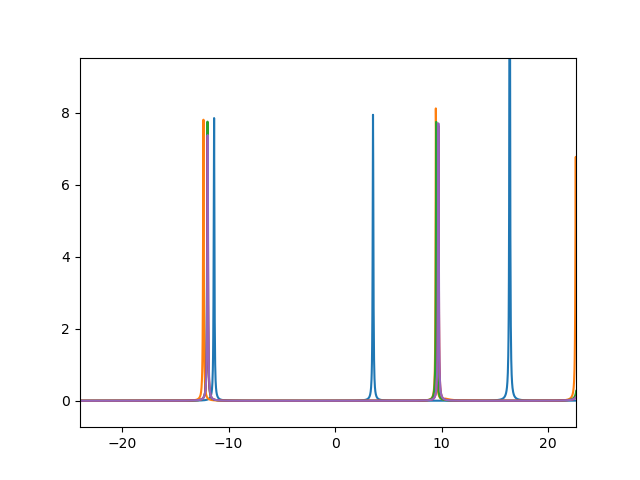

In [8]:
plt.plot(energies, gf0.get_dos())

In [15]:
D1 = step(D1)

In [16]:
plt.plot(energies, gf0.get_dos())